In [5]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

import re
import requests

color_palettes = ['Accent', 'BrBG', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu_r', 'Greens', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'PuBuGn_r', 'PuRd', 'RdBu']
# , , , Blues_r, , BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r



POS = 'NOUN'
top_N = 30
N_words_max = 10



# 1. Data preparation.

# Loads wcount csv files as a dict of dataframes (one per category).
def csvs_to_dict_of_dfs():

    print('Loading word counts CSV files into a dataframes:\
          \n------------------------------------------------')

    # Get data files_paths.
    base_path = os.getcwd() + '/data/word_counts/'
    csv_files = [f for f in os.listdir(base_path)]

    # Iterate over csv_files [categories].
    wcount_frames = {}
    for f in csv_files:

        # Open each csv file as a df.
        csv_file_path = base_path + f
        df = pd.read_csv(csv_file_path, encoding='utf-8')

        # Load each df to all frames dict. 
        category_name = f.split('.')[0]
        wcount_frames[category_name] = df

        print('{:20}: {} ({} words).'.format(category_name, f, len(df)))
        
    return wcount_frames

# Takes a dict of frames (1 df/category) of words ordered by occurrence (starting from top),
# returns a dict of frames of N samples of a pos kind ('ADJ' or 'NOUN' or 'VERB' etc)
def get_N_most_occuring_words_of_a_kind(dict_of_frames, N, kind):
    frames_out = {}
    for i, k in enumerate(dict_of_frames.keys()):
        df_raw = dict_of_frames[k]
        df = df_raw[df_raw.part_of_speach == kind].iloc[:N,:]
        
        # Add_relative_percentage_word count statistic.
        df['percent'] = np.round( df['count'] / len(df_raw)*100, 2)

        frames_out[k] = df
    
    return frames_out

# Returns ONE list of all words from all frames.
def get_all_words_from_all_frames(dict_of_frames):
    all_words = []
    for i, k in enumerate(dict_of_frames.keys()):
        df = dict_of_frames[k]
        all_words.extend(df['word'].to_list() )
    return all_words

# Returns all words list with extra parameters: word + avg percentage (regardless of category).
def get_all_words_from_all_frames_WITH_FEATURES(dict_of_frames):
    all_words_F = []
    for i, k in enumerate(dict_of_frames.keys()):
        df = dict_of_frames[k]
        all_words_F.append(zip(df['word'].to_list(), df['percent'].to_list() )  )
    all_words_F = [list(z) for z in all_words_F]
    return all_words_F

# Returns ordered list of all words (by relative percentate) within ALL cagegories.
def get_selected_words_param(all_words, all_words_F, all_words_uniq):
    
    all_words_dict = dict()
    
    # Add 2nd parameter 
    # ...
    
    # Dict of word : cumulative percentage in all categories.
    for w in all_words_uniq:
        all_words_dict[w] = (0)
    for word_data in all_words_F:
        for word, share_percent in word_data:
            all_words_dict[word] += share_percent
    
    # Round results for easyier reading.
    for word in all_words_dict:
        all_words_dict[word] = np.round((all_words_dict[word]/n_categories), 2)

    # Order results (descending).
    def take_second(element):
        return element[1]
    all_words_dict = sorted(all_words_dict.items(), key=take_second)[::-1]

    return all_words_dict

# Prepare data to visualisation. dict() = { 'word' : [param, param, param, etc.)], etc. }
def prepare_data_for_visualisation(selected_words_param, selected_words_F):
    selected_words_prepared = dict()
    for word, p in selected_words_param:

        word_data = []
        for category in selected_words_F:
            #print(category)
            category_words = [c[0] for c in category]
            if word in category_words:
                perc = [w[1] for w in category if w[0] == word][0]
                word_data.append(perc)
            else:
                word_data.append(0)
        selected_words_prepared[str(word)] = word_data
    return selected_words_prepared

wcount_frames = csvs_to_dict_of_dfs()
dict_of_frames = get_N_most_occuring_words_of_a_kind(wcount_frames, top_N, POS)
selected_words = get_all_words_from_all_frames(dict_of_frames)
selected_words_uniq = np.unique(selected_words)

selected_words_F = get_all_words_from_all_frames_WITH_FEATURES(dict_of_frames)
n_categories = len(selected_words_F)

selected_words_param = get_selected_words_param(selected_words, selected_words_F, selected_words_uniq)

prepared_word_dict = prepare_data_for_visualisation(selected_words_param, selected_words_F)

df_topw_ac = pd.DataFrame(prepared_word_dict)
df_topw_ac = df_topw_ac.T
df_topw_ac.columns = wcount_frames.keys()
df_topw_ac['word'] = df_topw_ac.index
df_topw_ac.index = range(len(df_topw_ac))
df_words = df_topw_ac.iloc[:,-1]
df_topw_ac = pd.concat([df_words, df_topw_ac], axis=1).iloc[:,:-1]

# Save df results
results_folder = 'top_words_categorised'
if not results_folder in os.listdir():
    os.mkdir(results_folder)
save_path = os.getcwd() + '/data/top_words_categorised/top_words_'+POS+'_'+str(top_N)+'.csv'
print('\nSaved as:', save_path)
df_topw_ac.to_csv(save_path, encoding='UTF-8', index=False)

# Show
display(df_topw_ac.head(2))
display(df_topw_ac.shape)


# Loading.
#POS = 'NOUN' # POS # ADJ NOUN VERB [craft more if needed in above code]
#top_N = 50 # top_N # 30 / 50
load_path = os.getcwd() + '/top_words_categorised/top_words_'+POS+'_'+str(top_N)+'.csv'
df_topw_all_c = pd.read_csv(load_path)
df_topw_all_c.head()

# Prepare data frame.
dfs = []
dict_of_frames2 = get_N_most_occuring_words_of_a_kind(wcount_frames, 30, POS)
for k, df in dict_of_frames2.items():
    df['category'] = k
    dfs.append(df)
    
df_all = pd.concat(dfs, axis=0)
df_all = df_all.sort_values('percent', axis=0, ascending=False, inplace=False)
df_all.reset_index(inplace=True, drop=True) #=False) 

df_all_w = df_all.iloc[:,:]

Loading word counts CSV files into a dataframes:          
------------------------------------------------
Positive            : Positive.csv (12959 words).
Behavioral genetics : Behavioral genetics.csv (25041 words).
Cultural            : Cultural.csv (8038 words).
Quantitative        : Quantitative.csv (16947 words).
Developmental       : Developmental.csv (22574 words).
Mathematical        : Mathematical.csv (12784 words).
Biological          : Biological.csv (12350 words).
Cross-cultural      : Cross-cultural.csv (8110 words).
Experimental        : Experimental.csv (19789 words).
Comperative         : Comperative.csv (13592 words).
Social              : Social.csv (23470 words).
Neuropsychology     : Neuropsychology.csv (12204 words).
Cognitive           : Cognitive.csv (16075 words).
Evolutionary        : Evolutionary.csv (24587 words).
Personality         : Personality.csv (21456 words).
Big Five            : Big Five.csv (16041 words).
Cognitivism         : Cognitivism.csv (979

,word,Positive,Behavioral genetics,Cultural,Quantitative,Developmental,Mathematical,Biological,Cross-cultural,Experimental,Comperative,Social,Neuropsychology,Cognitive,Evolutionary,Personality,Big Five,Cognitivism,Differential
0,use,3.53,8.64,3.37,6.31,8.07,7.78,3.84,3.18,7.08,4.43,8.35,5.79,7.71,6.38,7.08,7.10,4.12,7.20
1,study,4.47,5.58,4.70,4.40,6.97,5.41,4.06,3.38,5.59,2.24,9.29,3.97,6.66,6.04,5.18,6.65,3.27,5.53


(143, 19)


Category 0: Positive - 174 samples of ['may', 'make', 'find', 'include', 'develop', 'need', 'think', 'give', 'increase', 'become'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

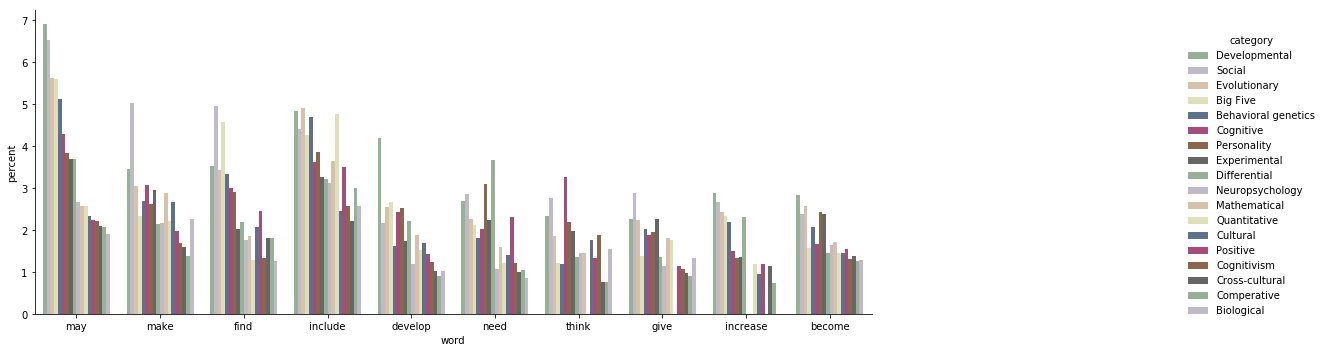


Category 1: Behavioral genetics - 158 samples of ['may', 'make', 'find', 'include', 'would', 'need', 'dna', 'show', 'give', 'increase'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

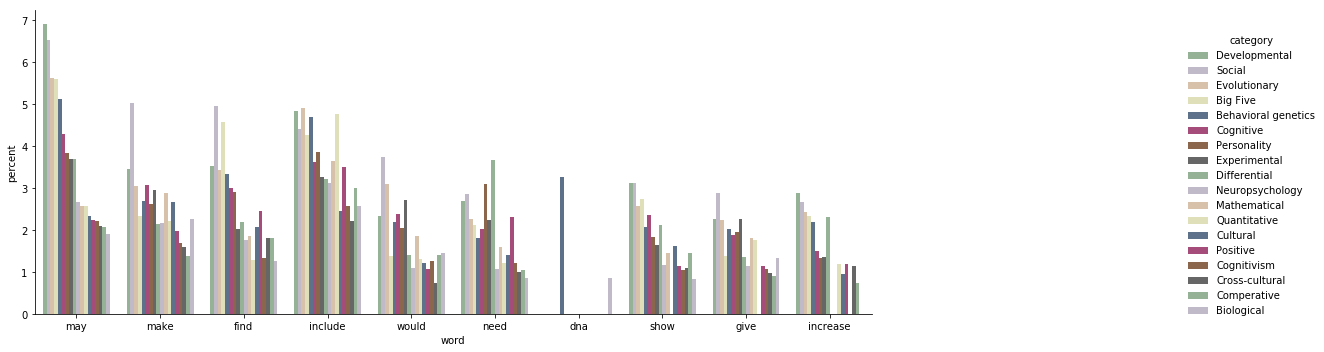


Category 2: Cultural - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'show'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

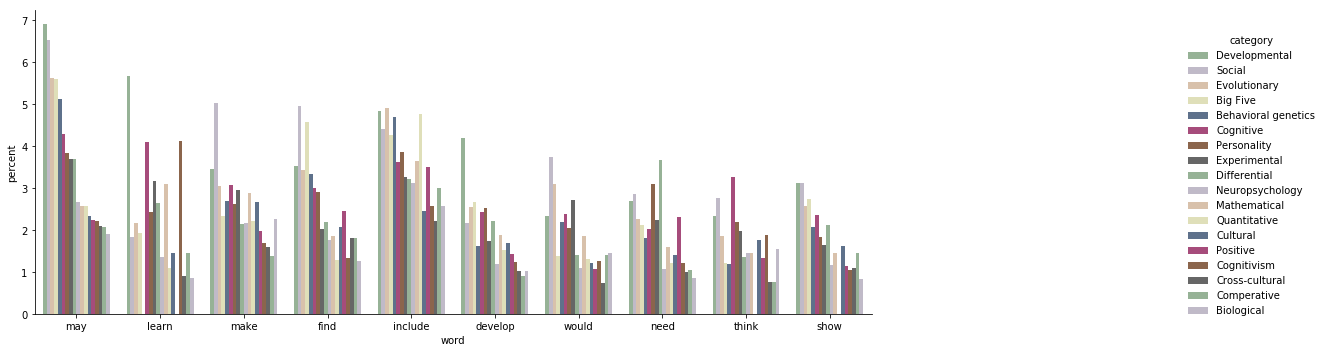


Category 3: Quantitative - 169 samples of ['may', 'make', 'include', 'develop', 'set', 'would', 'give', 'become', 'know', 'take'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

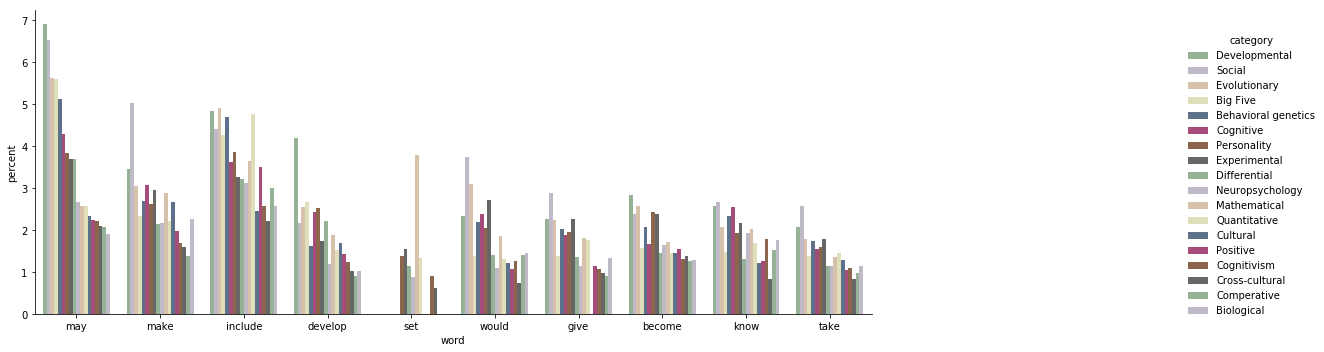


Category 4: Developmental - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'show'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

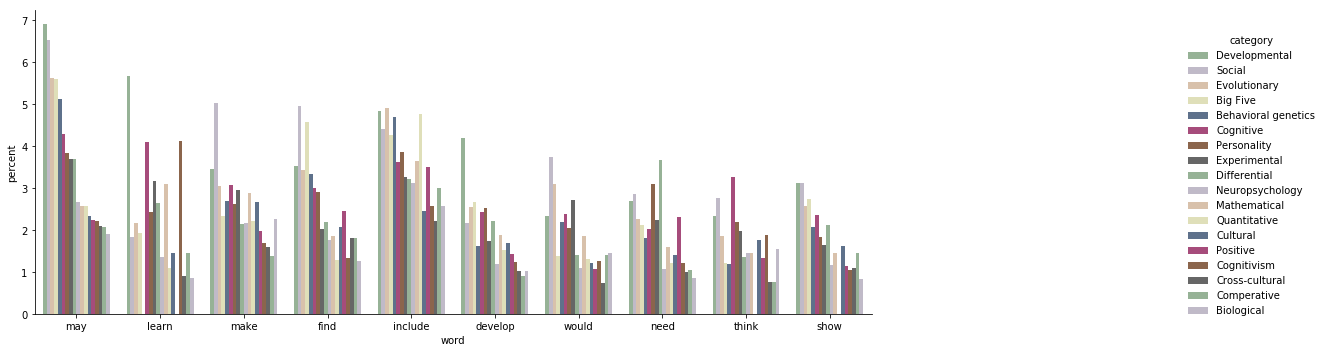


Category 5: Mathematical - 167 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'set', 'would', 'need', 'give'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

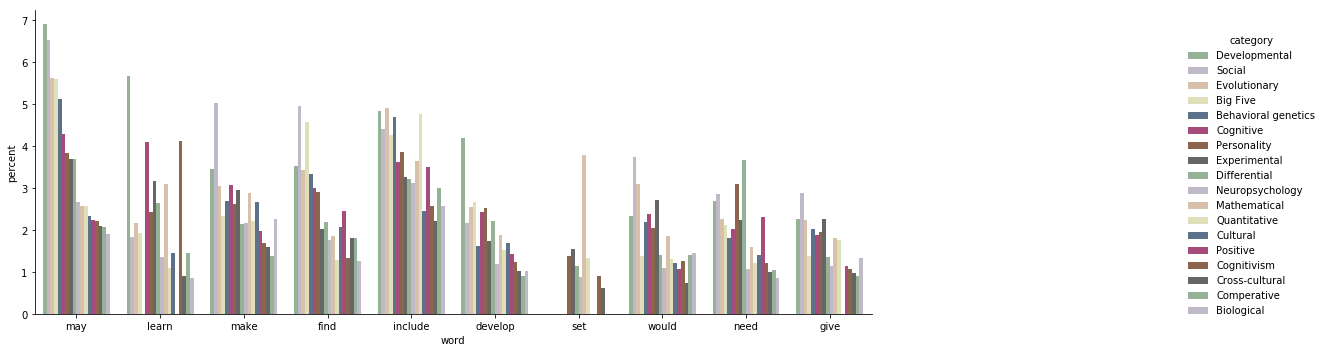


Category 6: Biological - 175 samples of ['may', 'make', 'find', 'include', 'would', 'think', 'give', 'become', 'understand', 'know'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

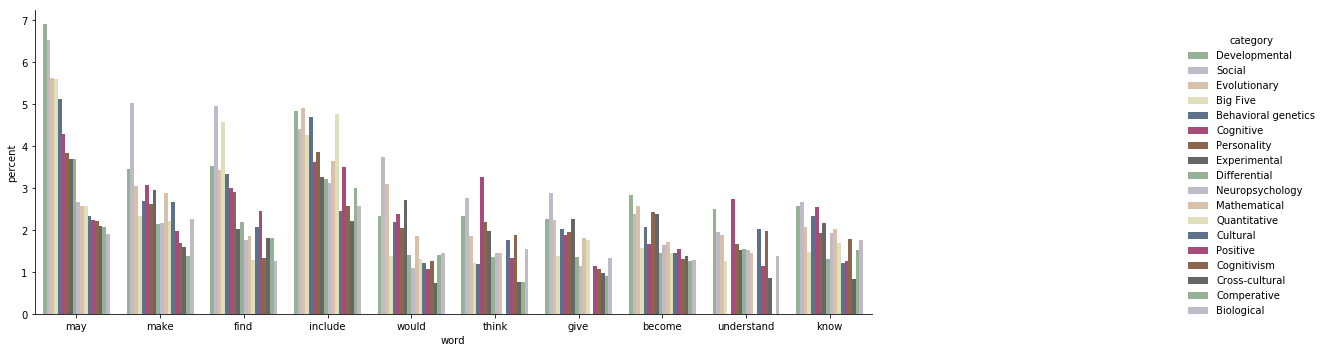


Category 7: Cross-cultural - 172 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'need', 'show', 'give', 'increase'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

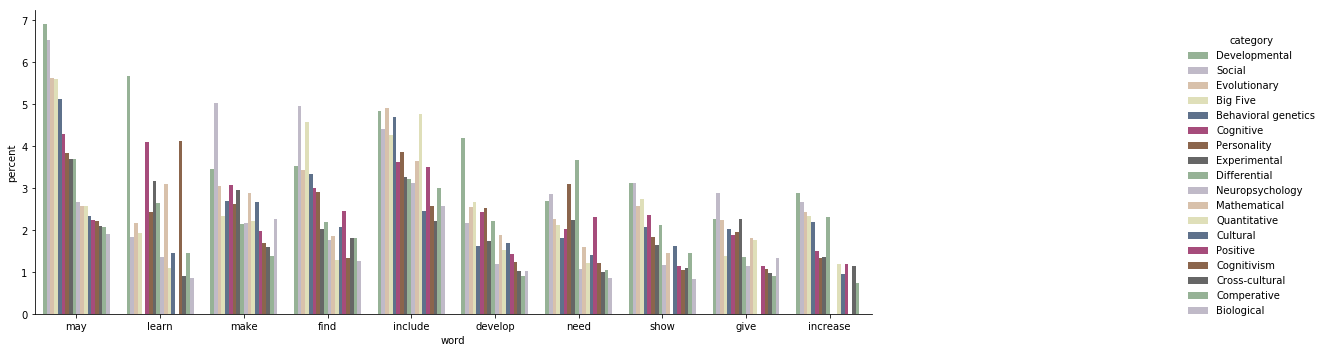


Category 8: Experimental - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'give'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

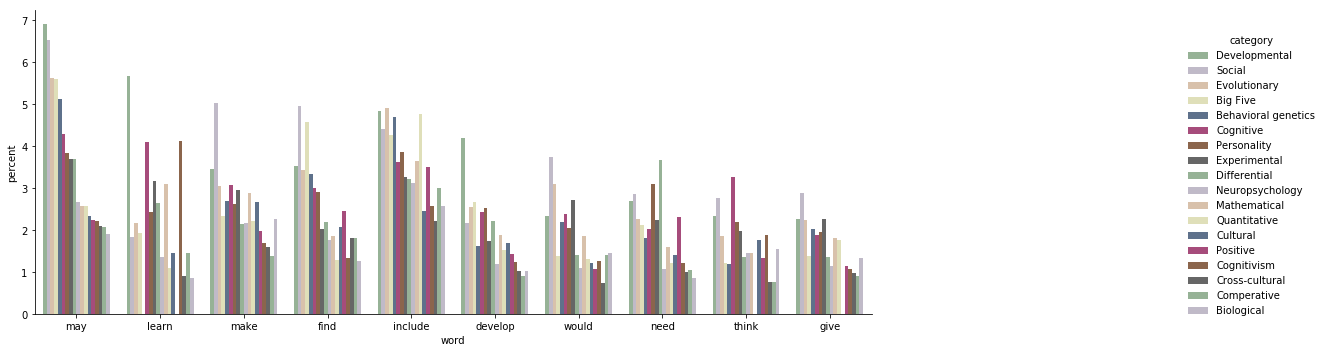


Category 9: Comperative - 177 samples of ['may', 'learn', 'make', 'find', 'include', 'would', 'need', 'show', 'become', 'know'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

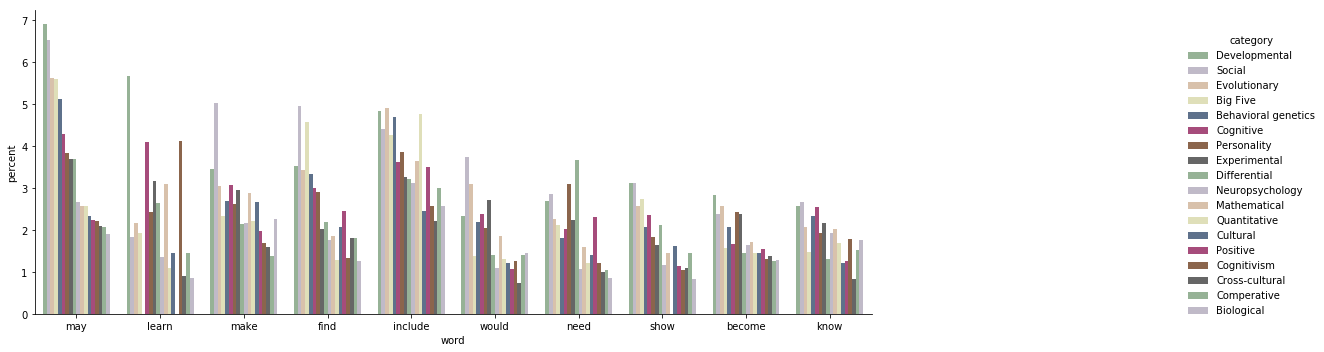


Category 10: Social - 173 samples of ['may', 'make', 'find', 'include', 'would', 'need', 'think', 'show', 'give', 'increase'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

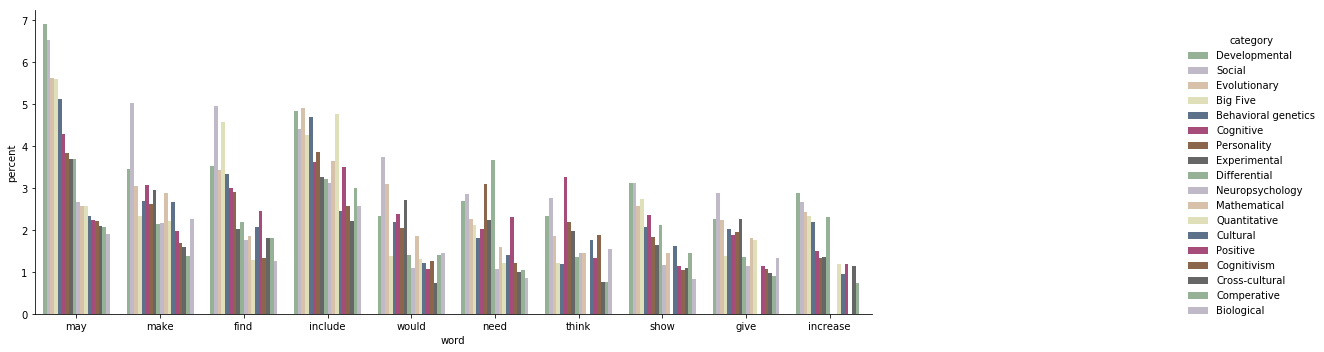


Category 11: Neuropsychology - 173 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'think', 'show', 'become', 'understand'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

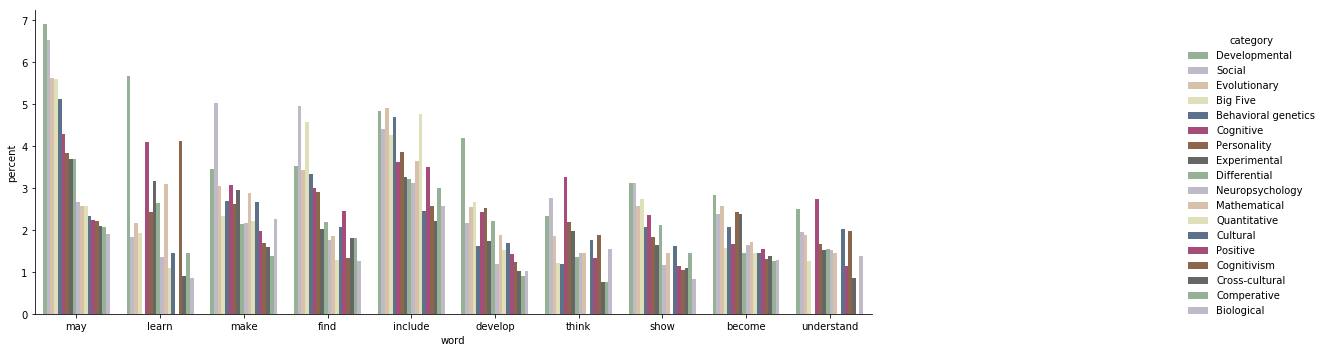


Category 12: Cognitive - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'show'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

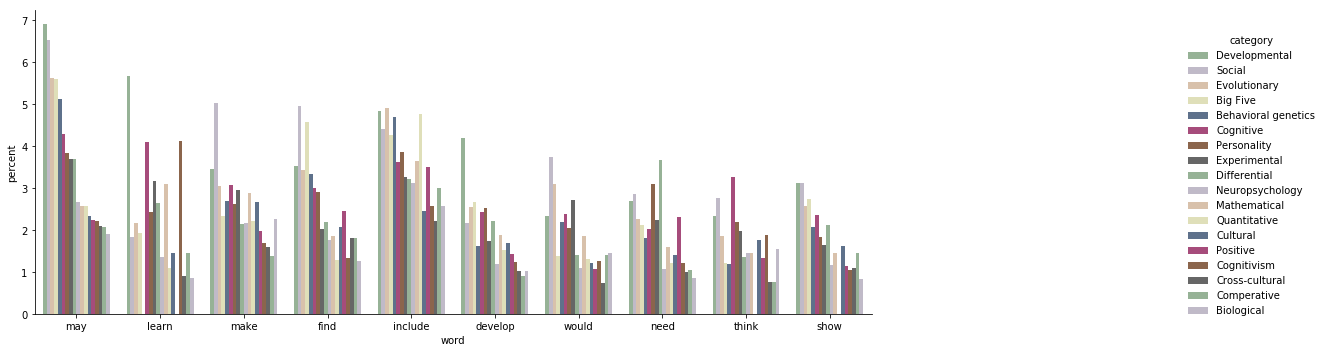


Category 13: Evolutionary - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'show', 'give'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

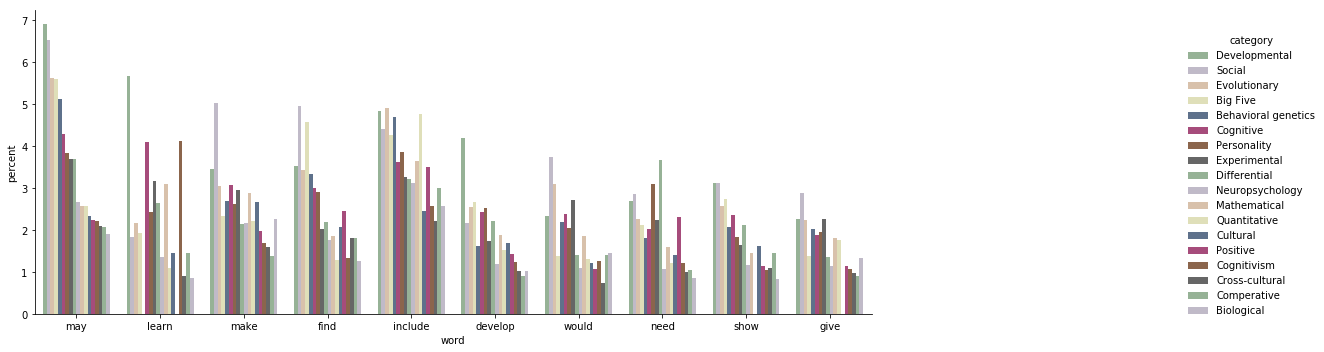


Category 14: Personality - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'show'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

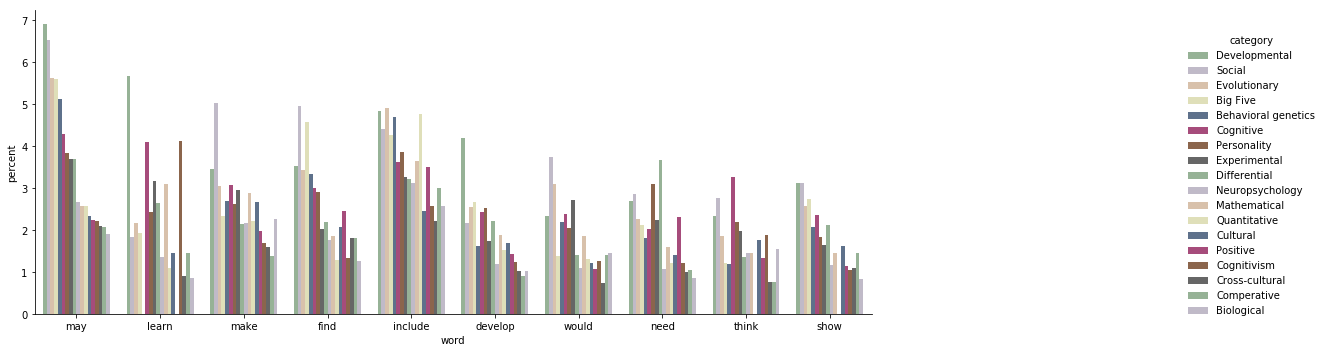


Category 15: Big Five - 173 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'need', 'show', 'increase', 'become'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

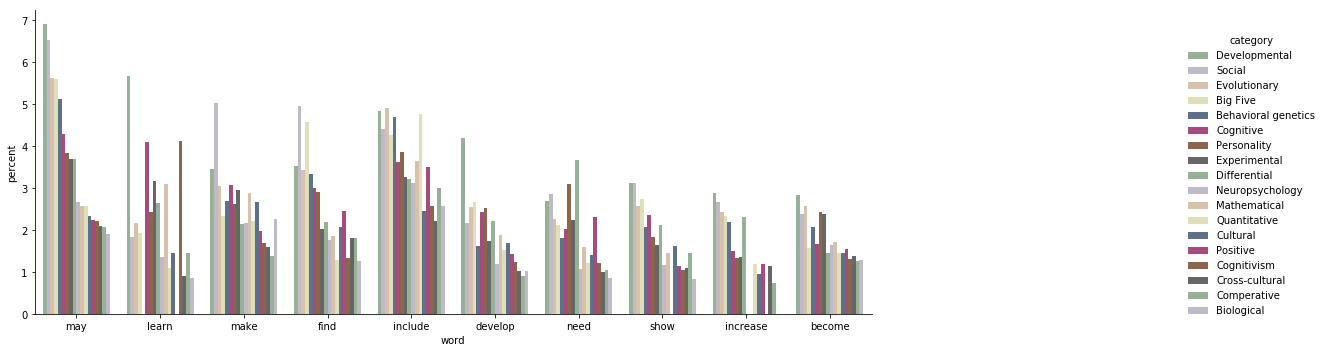


Category 16: Cognitivism - 177 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'become'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

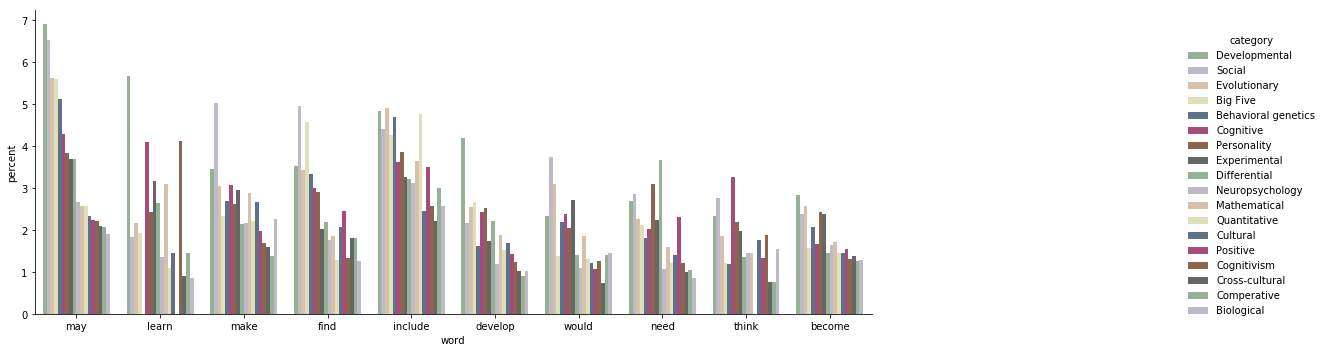


Category 17: Differential - 176 samples of ['may', 'learn', 'make', 'find', 'include', 'develop', 'would', 'need', 'think', 'show'] words across tops of categories.


<Figure size 432x288 with 0 Axes>

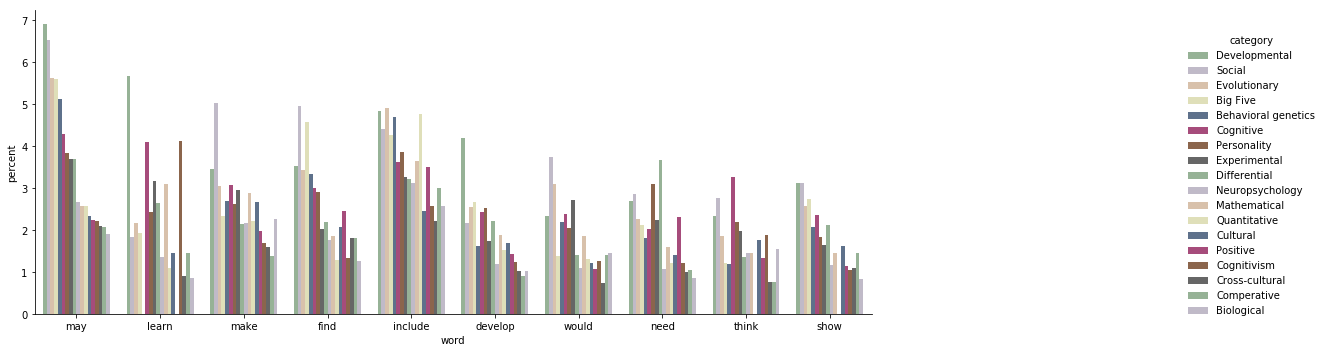

In [3]:
# 2. Visualise MOST N USED WORDS IN CAT C in compare to all other cats.

sns.set_palette(color_palettes[0], 50, .5)
used_words = []
for i, (k,v) in enumerate(wcount_frames.items()):

    df_c = wcount_frames[k]
    df_c = df_c[df_c.part_of_speach == POS]
    #display(df_c.head())
    top_words_from_this_category = df_c.word.to_list()[:15]
    #print(top_words_from_this_category)
    most_used_word_group = df_all_w.word.unique()
    word_group = [w for w in most_used_word_group if w in top_words_from_this_category]
    word_group = word_group[:N_words_max]
    if word_group:
        df_vis_b = []
        for word in word_group:
            df_vis = df_all_w[df_all_w.word == word]
            # SOLO
            df_vis_b.append(df_vis)
        
    # GROUPS
    df_vis = pd.concat(df_vis_b)
    print()
    #df_all_w = df_all_w.loc[:, word] 
    print('Category {}: {} - {} samples of {} words across tops of categories.'.format(i, k, df_vis.shape[0], word_group))
    figure = plt.figure()
    g = sns.catplot(x="word", y="percent", hue="category",kind="bar", margin_titles=True, data=df_vis);
    g.fig.set_size_inches(20,5)
    plt.show()